In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("bank-full.csv", sep=";")
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [4]:
numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

df = df[[
    'age',
    'job',
    'marital',
    'education',
    'balance',
    'housing',
    'contact',
    'day',
    'month',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'poutcome',
    'y'
]]

df = (
    df.assign(y=(df.y=="yes").astype(int))
)

In [6]:
from sklearn.model_selection import train_test_split

df_full_train, df_test, y_full_train, y_test = train_test_split(df[categorical + numerical], df.y, test_size=0.2, random_state=1)
df_train, df_val, y_train, y_val = train_test_split(df_full_train[categorical + numerical], y_full_train, test_size=0.25, random_state=1)

y_test = y_test.values
y_full_train = y_full_train.values
y_train = y_train.values
y_val = y_val.values

In [8]:
#question 1. ROC AUC feature importance
from sklearn.metrics import roc_auc_score

for col in ["balance", "day", "duration", "previous"]:
    print(col, roc_auc_score(y_train, df_train[col]))

balance 0.5888313805382317
day 0.474042117616092
duration 0.8147002759670778
previous 0.5985653242764153


In [10]:
#Question 2: Training the model
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

train_dicts = df_train[numerical+categorical].to_dict(orient="records")
val_dicts = df_val[numerical+categorical].to_dict(orient="records")

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred_val = model.predict_proba(X_val)[:, 1]

roc_auc_score(y_val, y_pred_val).round(3)

0.9

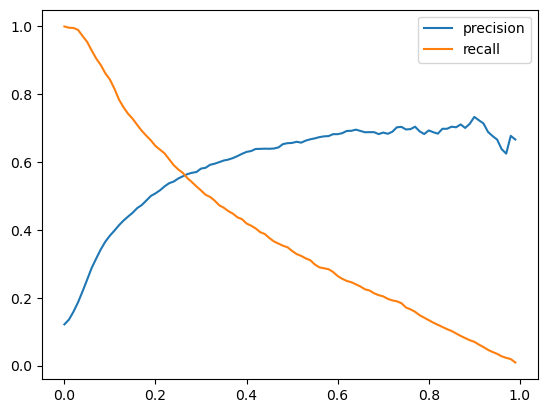

In [14]:
#Question 3: Precision and Recall
thresholds = np.arange(0, 1.0, 0.01)
precisions = []
recalls = []

for t in thresholds:
    tp = ((y_pred_val >= t) & (y_val == 1)).sum()
    fp = ((y_pred_val >= t) & (y_val == 0)).sum()
    fn = ((y_pred_val < t) & (y_val == 1)).sum()

    precisions.append(tp / (tp + fp))
    recalls.append(tp / (tp + fn))

plt.plot(thresholds, precisions, label="precision")
plt.plot(thresholds, recalls, label="recall")
plt.legend();

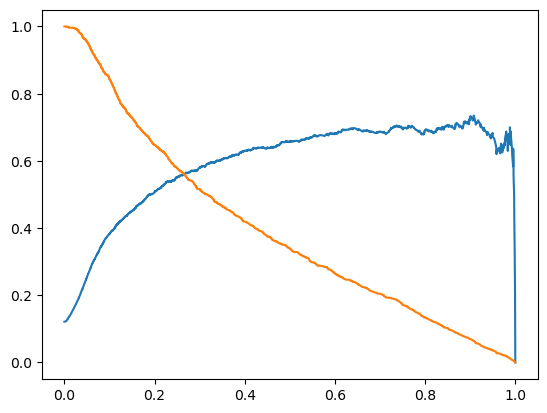

In [16]:
from sklearn.metrics import precision_recall_curve

# Calculate precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_val)

plt.plot(thresholds, precisions[:-1], label="precision")
plt.plot(thresholds, recalls[:-1], label="recall")

In [18]:
# intersection point is at 0.265(apx)

In [20]:
#Question 4: F1 score
thresholds = np.arange(0, 1.0, 0.01)
f_1 = []

for t in thresholds:
    tp = ((y_pred_val >= t) & (y_val == 1)).sum()
    fp = ((y_pred_val >= t) & (y_val == 0)).sum()
    fn = ((y_pred_val < t) & (y_val == 1)).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    f_1.append(2 * precision * recall / (precision + recall))

thresholds[np.argmax(np.array(f_1))]

0.22

In [22]:
#Question 5: 5-Fold CV
from sklearn.model_selection import KFold
from tqdm.auto import tqdm


kfold = KFold(n_splits=5, shuffle=True, random_state=1)
kfold.split(df_full_train)

scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    
    train_dicts = df_full_train.iloc[train_idx].to_dict(orient="records")
    val_dicts = df_full_train.iloc[val_idx].to_dict(orient="records")

    # Slice the target values using the train and validation indices
    y_train_fold = y_full_train[train_idx]
    y_val_fold = y_full_train[val_idx]

    dv = DictVectorizer(sparse=False)

    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)
    model.fit(X_train, y_train_fold)

    y_pred_val = model.predict_proba(X_val)[:, 1]

    scores.append(roc_auc_score(y_val_fold, y_pred_val))

0it [00:00, ?it/s]

In [24]:
np.std(scores).round(3)

0.006